In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams

import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogFormatterSciNotation

from lmfit import Model

/home/gokul/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
sns.set_style('whitegrid')
rcParams['figure.dpi'] = 300
rcParams['figure.figsize'] = (4, 3)
rcParams['grid.linewidth'] = 0.5
rcParams['grid.linestyle'] = 'dashed'
rcParams['legend.fancybox'] = False
rcParams['mathtext.fontset'] = 'stix'
rcParams['xtick.major.pad']='0'
rcParams['ytick.major.pad']='1'

dpi = 150


c6 = ['#c4bae2','#40ada6','#3c4ebf',  
        '#e3a600', '#edb1a3', '#d6543a',]
pretty_palette = [c6[c] for c in range(6) if c in [1,2,3,5]]

In [3]:
merf_df = pd.read_csv('../results/MERFISH_scaling.csv', index_col=0)
cite_df = pd.read_csv('../results/PBMC_CITEseq_scaling.csv', index_col=0)
larry_df = pd.read_csv('../results/LARRY_scaling.csv', index_col=0)

dfs = [merf_df, cite_df, larry_df]

for df in dfs:
    df.replace("RandomProjection", "Rand. proj.", inplace=True)
    df.replace("nanoTxformer", "Txformer", inplace=True)

hue_order = ["VAE", "PCA", "Txformer", "Rand. proj."]

In [4]:
def add_delta_mi(df, mi_column):
    avg_random_proj = (
        df[df["Method"] == "Rand. proj."]
        .groupby("UMI per cell")[mi_column]
        .transform("mean")
    )
    df["avg_random_proj"] = df["UMI per cell"].map(
        df[df["Method"] == "Rand. proj."]
        .groupby("UMI per cell")[mi_column]
        .mean()
    )
    df[f"delta {mi_column}"] = df[mi_column] - df['avg_random_proj']
    df[f"Info gain ({mi_column})"] = df[f"delta {mi_column}"] / np.log10(df['Cell number'])
    return df

cite_df = add_delta_mi(cite_df, "Protein MI")
cite_df = add_delta_mi(cite_df, "Cell type fine MI")
merf_df = add_delta_mi(merf_df, "Spatial neighborhood MI")
larry_df = add_delta_mi(larry_df, "Clonal MI")

In [5]:
def cell_number_scaling(x, A, B, C):
    return C - (x/A)**B

def info_scaling(x, A, B):
    return 0.5 * np.log2((x*B+ 1)/(1+A*x))

In [6]:
d = {
    "Method" : [],
    "Metric" : [],
    "Quality" : [],
    "A" : [],
    "A std err" : [],
    "B" : [],
    "B std err" : [], 
    "C" : [],
    "C std err" : []
}

dfs = [merf_df, larry_df, cite_df, cite_df]

names = ['Spatial MI', 'Clonal MI', 'Protein MI', 'Cell type MI']
mi_keys = ['Spatial neighborhood MI', 'Clonal MI', 'Protein MI', 'Cell type fine MI']


# fig, axs = plt.subplots(1, 2, figsize=(4, 1.5), dpi=dpi, sharey=True)

for i, df in enumerate(dfs):
    mi_k = mi_keys[i]
    for method in hue_order:
        for upc in df['UMI per cell'].unique():
            sub_df = df[(df['UMI per cell'] == upc) & (df['Method'] == method)]
            x_data = sub_df['Cell number']
            y_data = sub_df[mi_k]

            model = Model(cell_number_scaling)
            params = model.make_params(A=dict(value=10**3, min=1e-6), 
                                B=dict(value=1, min=1e-6),
                                C=dict(value=1, min=1e-6))
            result = model.fit(y_data, params, x=x_data)

            if method in ['PCA', 'VAE', 'Txformer', 'Rand. proj.']:# and upc == df['UMI per cell'].max():

                # ax = axs[hue_order.index(method)]
                # ax.scatter(x_data, y_data, label=names[i], color=pretty_palette[i], s=10)

                x_fit = np.logspace(np.log10(np.min(x_data)), 6, 100)
                y_fit = result.eval(x=x_fit)

                # ax.plot(x_fit, y_fit, color=pretty_palette[i], lw=1, linestyle='--')

                y_upper = result.eval_uncertainty(params=result.params, 
                                    x=x_fit, sigma=2)
                y_lower = -y_upper
                # ax.fill_between(x_fit, y_fit + y_upper, y_fit + y_lower, 
                #                 color=pretty_palette[i], alpha=0.2)
                
                # ax.set_xscale('log')
                # ax.set_ylim(0, 5)
                # ax.set_xlabel('Cell number')

                print(method, names[i])
                # print(result.eval(x=np.max(x_data)*10) - result.eval(x=np.max(x_data)))
                # print(result.eval_uncertainty(x=np.max(x_data)*10, params=result.params, sigma=1))
                print(result.params['C'].value, result.params['C'].stderr)
                print(result.params['B'].value, result.params['B'].stderr)
                print(result.params['A'].value, result.params['A'].stderr)
                print()


            # print(result.params['A'].value/0.1**(-result.params['B'].value))

                d['Method'].append(method)
                d['Metric'].append(names[i])
                d['Quality'].append(sub_df['Quality'].unique()[0][1:])
                d['A'].append(result.params['A'].value)
                d['A std err'].append(result.params['A'].stderr)
                d['B'].append(result.params['B'].value)
                d['B std err'].append(result.params['B'].stderr)
                d['C'].append(result.params['C'].value)
                d['C std err'].append(result.params['C'].stderr)

# axs[0].set_ylabel('Repr. info (bits)')
# axs[0].set_title('VAE')
# axs[1].set_title('PCA')
# plt.legend(loc=(1.05, 0.1))

/tmp/ipykernel_880987/171644539.py:2: RuntimeWarning: overflow encountered in power
  return C - (x/A)**B
/home/gokul/.local/lib/python3.10/site-packages/lmfit/model.py:1736: RuntimeWarning: overflow encountered in multiply
  df2[key] += fjac[key][i] * fjac[key][j] * covar[i, j]
/home/gokul/.local/lib/python3.10/site-packages/lmfit/model.py:1736: RuntimeWarning: invalid value encountered in multiply
  df2[key] += fjac[key][i] * fjac[key][j] * covar[i, j]
/home/gokul/.local/lib/python3.10/site-packages/lmfit/model.py:1736: RuntimeWarning: invalid value encountered in add
  df2[key] += fjac[key][i] * fjac[key][j] * covar[i, j]


VAE Spatial MI
0.0074993799997563615 0.006568230233868801
20.022081019653264 9499793.588063123
63226.04274101211 6524698838.146578

VAE Spatial MI
0.004988993791005147 0.018802164578070765
22.09191970562721 2.765404058051961e+24
170258.52850448492 2.8854288481201314e+28

VAE Spatial MI
0.031413220594317504 None
29.58266476287788 None
3857653.760787143 None

VAE Spatial MI
0.06689185359705918 None
57.43046885548206 None
157181.41894673536 None

VAE Spatial MI
0.180390882533903 0.030056109160178836
23.937242870707166 8.302940046998506e+24
145545.27795839068 5.518165609670034e+28

VAE Spatial MI
0.3417704153461435 0.07388196896367188
26.133774739105558 1.0889300950153908e+25
136977.13949020382 5.858137104233317e+28

VAE Spatial MI
1.691635305824318 None
1.0000008024979579e-06 None
34593.43684770803 None

VAE Spatial MI
2.1424380938749468 None
1.0000009694755008e-06 None
24460.52635767978 None

VAE Spatial MI
2.5722355408846562 None
1.0000000000287557e-06 None
24955.96544988055 None

VAE S

 None

Txformer Spatial MI
0.29058318416009044 0.048366034785170896
7.670260629337297 34665349.85383612
75572.47516150089 135634619016.48091

Txformer Spatial MI
0.29152882056856966 None
111.20726253744805 None
223275.12465282902 None

Rand. proj. Spatial MI
0.003291848552278931 None
318.35521249958276 None
11357513.993898038 None

Rand. proj. Spatial MI
0.0063712715392093555 0.005163780061469311
11.94147630396986 167945.58429953136
90234.30497442333 743447771.1027229

Rand. proj. Spatial MI
0.023776141764029757 0.002840828001123934
17.83596113793907 1433171.2934144596
67458.14916636707 1544158629.7042003

Rand. proj. Spatial MI
0.03142730785295489 None
59.39529279791881 None
319781.84674932796 None

Rand. proj. Spatial MI
0.05097444008507501 0.007779271377543683
1.5572388184166326 18.298858086007634
1631268.356408461 67151341.55230689

Rand. proj. Spatial MI
0.08528862612902721 0.010081099787026957
19.557414104054452 3852448.444179187
60585.029164180305 2097992947.6210084

Rand. proj.

/tmp/ipykernel_880987/1421514066.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
/tmp/ipykernel_880987/1421514066.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
/tmp/ipykernel_880987/1421514066.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
/tmp/ipykernel_880987/1421514066.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=0)


Text(0, 0.5, '$I_\\infty$')

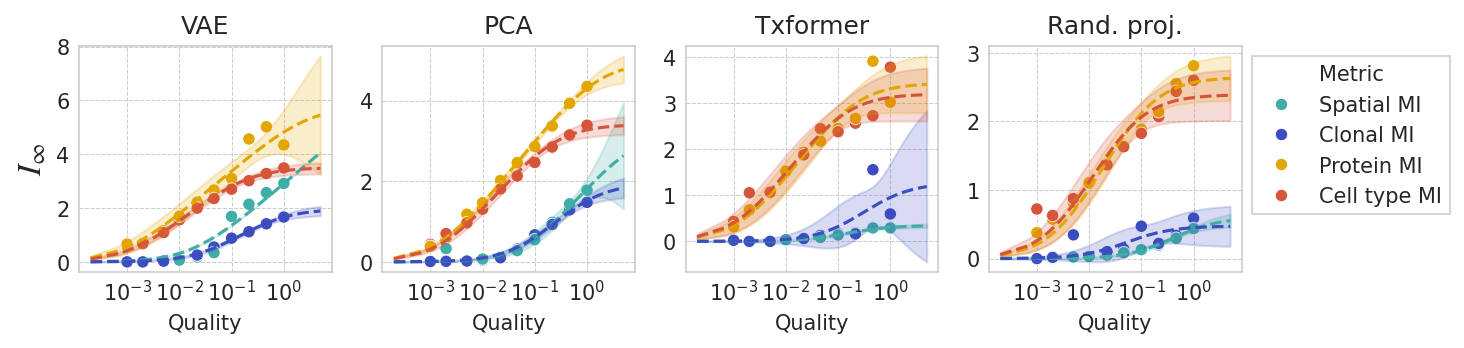

In [7]:
fig, axs = plt.subplots(1, 4, figsize=(10, 2), dpi=dpi)

for ax, method in zip(axs, hue_order):
    df_method = pd.DataFrame(d).query("Method == @method").sort_values("Quality")
    df_method['Quality'] = [float(x) for x in df_method['Quality'].values]
    high_conf = df_method[df_method['C std err'] < 1]
    high_conf = df_method
    sns.scatterplot(
        data=high_conf, x='Quality', y='C', hue='Metric', 
        legend=ax==axs[-1], palette=pretty_palette, hue_order = names, ax=ax, 
    )

    for metric in names:
        subset = high_conf[high_conf['Metric'] == metric]

        x_data = subset['Quality'].values*10**5
        y_data = subset['C'].values

        model = Model(info_scaling)
        params = model.make_params(A=1e-3, B=1e-3)  # initial guesses
        params['A'].min = 0  # set bounds
        params['B'].min = 0

        # fit model
        result = model.fit(y_data, params, x=x_data)

        # print(x_data)
        # print(y_data)
        # print(result.fit_report())
        # break

        x_fit = np.linspace(x_data.min()/5, 5*x_data.max(), 10**4)
        y_fit = model.eval(params=result.params, x=x_fit)

        # calculate confidence bands
        # https://www.astro.rug.nl/software/kapteyn/kmpfittutorial.html#confidence-and-prediction-intervals
        
        y_upper = result.eval_uncertainty(params=result.params, 
                                        x=x_fit, sigma=2)
        y_lower = -y_upper

        ax.fill_between(x_fit/10**5, y_fit + y_upper, y_fit + y_lower, color=pretty_palette[names.index(metric)], alpha=0.2)

        ax.plot(x_fit/10**5, y_fit, color=pretty_palette[names.index(metric)], linestyle='--')

    ax.set_ylabel('')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    ax.set_title(method)
    ax.set_xscale('log')


sns.move_legend(axs[-1], "upper left", bbox_to_anchor=(1, 1))

axs[0].set_ylabel(r'$I_\infty$', fontsize=16)




/tmp/ipykernel_880987/1623491989.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
/tmp/ipykernel_880987/1623491989.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=0)


Text(0, 0.5, '$I_\\infty$')

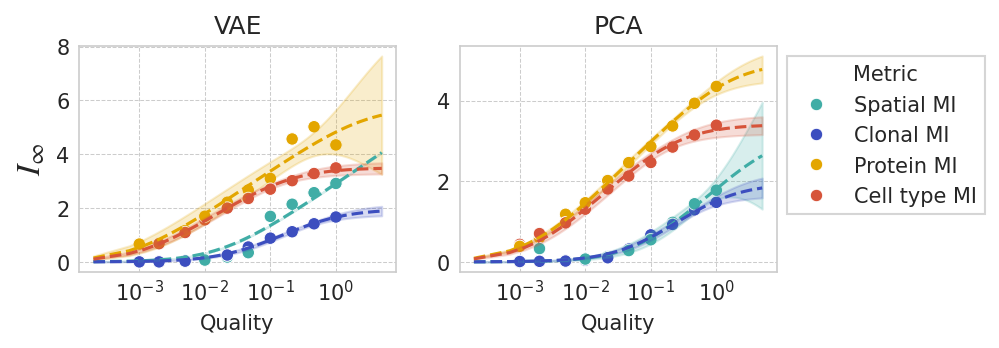

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(6, 2), dpi=dpi)

for ax, method in zip(axs, hue_order[:2]):
    df_method = pd.DataFrame(d).query("Method == @method").sort_values("Quality")
    df_method['Quality'] = [float(x) for x in df_method['Quality'].values]
    high_conf = df_method[df_method['C std err'] < 1]
    high_conf = df_method
    sns.scatterplot(
        data=high_conf, x='Quality', y='C', hue='Metric', 
        legend=ax==axs[-1], palette=pretty_palette, hue_order = names, ax=ax, 
    )

    for metric in names:
        subset = high_conf[high_conf['Metric'] == metric]

        x_data = subset['Quality'].values*10**5
        y_data = subset['C'].values

        model = Model(info_scaling)
        params = model.make_params(A=1e-3, B=1e-3)  # initial guesses
        params['A'].min = 0  # set bounds
        params['B'].min = 0

        # fit model
        result = model.fit(y_data, params, x=x_data)

        # print(x_data)
        # print(y_data)
        # print(result.fit_report())
        # break

        x_fit = np.linspace(x_data.min()/5, 5*x_data.max(), 10**4)
        y_fit = model.eval(params=result.params, x=x_fit)

        # calculate confidence bands
        # https://www.astro.rug.nl/software/kapteyn/kmpfittutorial.html#confidence-and-prediction-intervals
        
        y_upper = result.eval_uncertainty(params=result.params, 
                                        x=x_fit, sigma=2)
        y_lower = -y_upper

        ax.fill_between(x_fit/10**5, y_fit + y_upper, y_fit + y_lower, color=pretty_palette[names.index(metric)], alpha=0.2)

        ax.plot(x_fit/10**5, y_fit, color=pretty_palette[names.index(metric)], linestyle='--')

    ax.set_ylabel('')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    ax.set_title(method)
    ax.set_xscale('log')


sns.move_legend(axs[-1], "upper left", bbox_to_anchor=(1, 1))

axs[0].set_ylabel(r'$I_\infty$', fontsize=16)


/tmp/ipykernel_880987/3571081295.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # adjust layout to avoid overlap


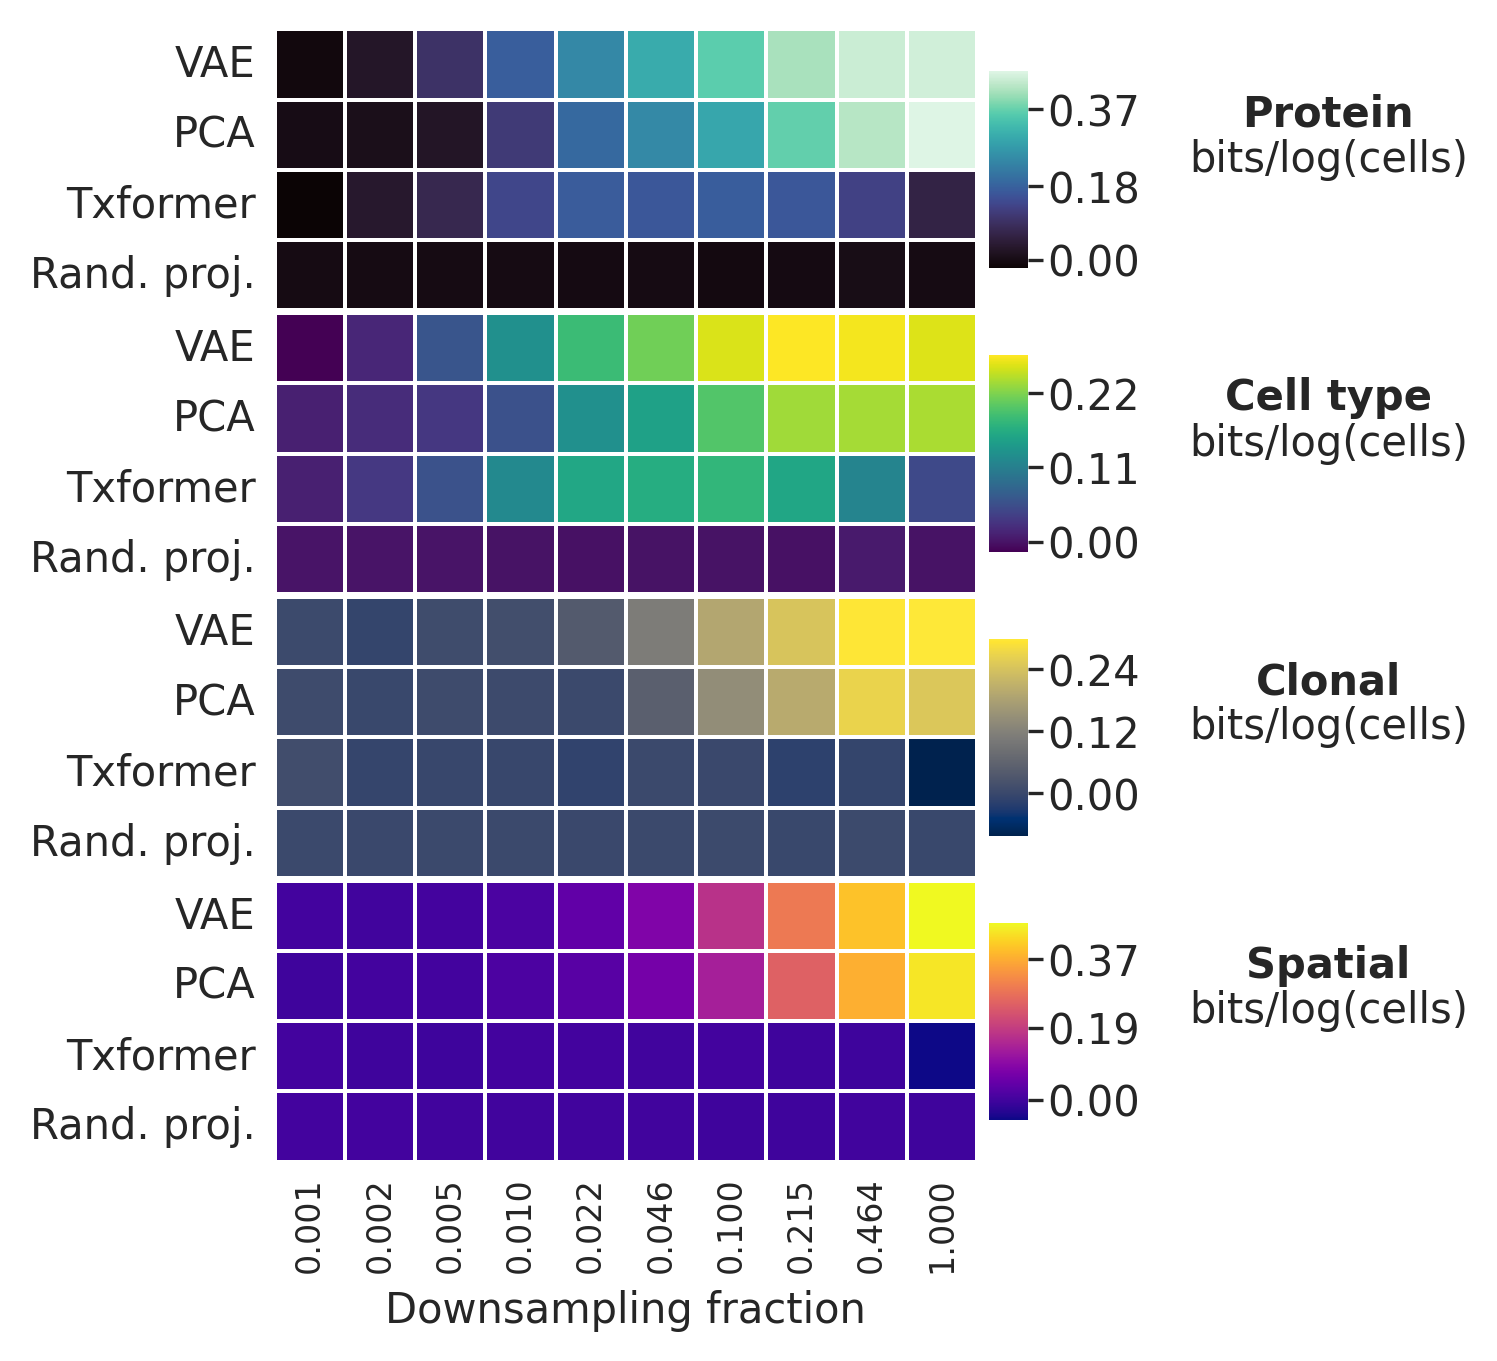

In [9]:
# prepare the data for each heatmap

palettes = ['mako', 'viridis', 'cividis', 'plasma']
heatmaps_data = [
    cite_df.pivot_table(columns='Quality', index='Method', 
                        values='Info gain (Protein MI)', aggfunc='mean'),
    cite_df.pivot_table(columns='Quality', index='Method', 
                        values='Info gain (Cell type fine MI)', aggfunc='mean'),
    larry_df.pivot_table(columns='Quality', index='Method', 
                         values='Info gain (Clonal MI)', aggfunc='mean'),
    merf_df.pivot_table(columns='Quality', index='Method', 
                        values='Info gain (Spatial neighborhood MI)', aggfunc='mean'),
]

order = ['Protein', 'Cell type', 'Clonal', 'Spatial']

# set up the figure and axes
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(5,5), 
                         gridspec_kw={'hspace': 0.01}, dpi=300)  # control spacing between rows

# plot each heatmap with its own colorbar
for palette, data, ax in zip(palettes, heatmaps_data, axes):
    heatmap = sns.heatmap(data.reindex(['VAE', 'PCA', 'Txformer', 'Rand. proj.']), 
                          ax=ax, square=True, cmap=palette, cbar=True, 
                cbar_kws={'shrink': 0.7, 'aspect': 5, 'pad':0.01,
                          'ticks': [np.round(x, 2) for x in np.linspace(0, data.max().max()*0.8, 3)]},
                        #   'label' : 'Spatial \n info gain'},
                lw=0.5)
    ax.set_xlabel('')  # hide x-axis labels for now
    ax.set_ylabel('')  # optional: remove y-axis labels for compactness
    # ax.set_title('hi')
    # ax.set_yticklabels(ax.get_yticklabels(), fontsize=8)
    if ax is not axes[-1]:
        ax.set_xticklabels([])
    else:
        ax.set_xticklabels([x.get_text()[1:] for x in ax.get_xticklabels()], fontsize=8)
df
# only add shared x-axis label to the bottom heatmap
axes[-1].set_xlabel('Downsampling fraction')


for i, name in enumerate(order):
    axes[i].text(15, 1.5, name, va='bottom', ha='center', rotation='horizontal', fontsize=10, weight='bold')
    axes[i].text(15, 1.5, '\nbits/log(cells)', va='center', ha='center', rotation='horizontal', fontsize=10)


plt.tight_layout()  # adjust layout to avoid overlap
plt.show()


In [10]:
fcs = []

q1 = 'Q1.000'
q2 = 'Q0.100'

for i, data in enumerate(heatmaps_data):
    
    
    fcs.append(data.loc['VAE'][q1]/data.loc['VAE'][q2])
    fcs.append(data.loc['PCA'][q1]/data.loc['PCA'][q2])

print(np.mean(fcs))
print(np.min(fcs))
print(order[fcs.index(np.min(fcs))//2])
print()
print(np.max(fcs))
print(order[fcs.index(np.max(fcs))//2])

1.7928872264713782
1.0038679189023982
Cell type

3.2598475513504646
Spatial
